# Face detection and recognition inference pipeline

The following example illustrates how to use the `facenet_pytorch` python package to perform face detection and recogition on an image dataset using an Inception Resnet V1 pretrained on the VGGFace2 dataset.

The following Pytorch methods are included:
* Datasets
* Dataloaders
* GPU/CPU processing

In [1]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
import numpy as np
import pandas as pd
import os

workers = 0 if os.name == 'nt' else 4

#### Determine if an nvidia GPU is available

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


#### Define MTCNN module

Default params shown for illustration, but not needed. Note that, since MTCNN is a collection of neural nets and other code, the device must be passed in the following way to enable copying of objects when needed internally.

See `help(MTCNN)` for more details.

In [3]:
mtcnn = MTCNN(
    image_size=128, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

#### Define Inception Resnet V1 module

Set classify=True for pretrained classifier. For this example, we will use the model to output embeddings/CNN features. Note that for inference, it is important to set the model to `eval` mode.

See `help(InceptionResnetV1)` for more details.

In [4]:
# resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)
# resnet = torch.load('./log/best_state.pth')
from models import FaceNetModel
model = FaceNetModel().to(device)
state = torch.load('./log/best_state.pth')
model.load_state_dict(state["state_dict"])

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

#### Define a dataset and data loader

We add the `idx_to_class` attribute to the dataset to enable easy recoding of label indices to identity names later one.

In [9]:
def collate_fn(x):
    return x[0]

dataset = datasets.ImageFolder('../data/test_images')
dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}
loader = DataLoader(dataset, collate_fn=collate_fn, num_workers=workers)

FileNotFoundError: [Errno 2] No such file or directory: '../data/test_images'

#### Perfom MTCNN facial detection

Iterate through the DataLoader object and detect faces and associated detection probabilities for each. The `MTCNN` forward method returns images cropped to the detected face, if a face was detected. By default only a single detected face is returned - to have `MTCNN` return all detected faces, set `keep_all=True` when creating the MTCNN object above.

To obtain bounding boxes rather than cropped face images, you can instead call the lower-level `mtcnn.detect()` function. See `help(mtcnn.detect)` for details.

In [86]:
aligned = []
names = []
for x, y in loader:
    x_aligned, prob = mtcnn(x, return_prob=True)
    if x_aligned is not None:
        print('Face detected with probability: {:8f}'.format(prob))
        aligned.append(x_aligned)
        names.append(dataset.idx_to_class[y])

Face detected with probability: 0.999983
Face detected with probability: 0.997395
Face detected with probability: 0.999967
Face detected with probability: 0.998569
Face detected with probability: 0.999934
Face detected with probability: 0.999987
Face detected with probability: 0.999733
Face detected with probability: 0.999876
Face detected with probability: 0.987209
Face detected with probability: 0.999992


#### Calculate image embeddings

MTCNN will return images of faces all the same size, enabling easy batch processing with the Resnet recognition module. Here, since we only have a few images, we build a single batch and perform inference on it. 

For real datasets, code should be modified to control batch sizes being passed to the Resnet, particularly if being processed on a GPU. For repeated testing, it is best to separate face detection (using MTCNN) from embedding or classification (using InceptionResnetV1), as calculation of cropped faces or bounding boxes can then be performed a single time and detected faces saved for future use.

In [87]:
aligned = torch.stack(aligned).to(device)
embeddings = resnet(aligned).detach().cpu()

#### Print distance matrix for classes

In [88]:
dists = [[(e1 - e2).norm().item() for e2 in embeddings] for e1 in embeddings]
print(pd.DataFrame(dists, columns=names, index=names))

                angelina_jolie  angelina_jolie  ariana_grande  ariana_grande  \
angelina_jolie        0.000000        0.939664       7.210462       3.006278   
angelina_jolie        0.939664        0.000000       6.476355       2.215853   
ariana_grande         7.210462        6.476355       0.000000       4.309261   
ariana_grande         3.006278        2.215853       4.309261       0.000000   
bradley_cooper        5.150895        4.237260       4.954765       3.254289   
harry                 2.672436        1.786965       4.936893       0.817941   
kate_siegel           5.175475        4.443474       4.670831       3.003805   
paul_rudd             4.124321        3.260095       5.024292       2.483489   
ron                   0.734758        0.371330       6.661896       2.407146   
shea_whigham          5.446777        4.616420       4.644677       3.390648   

                bradley_cooper     harry  kate_siegel  paul_rudd       ron  \
angelina_jolie        5.150895  2.672436 

# Test : single face picture

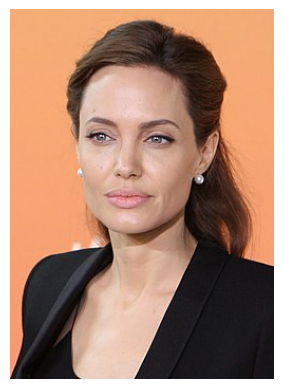

In [5]:
from torchvision import transforms
import matplotlib.pyplot as plt
import urllib
from PIL import Image

mtcnn = MTCNN(keep_all=False)

img = Image.open(urllib.request.urlopen("https://upload.wikimedia.org/wikipedia/commons/thumb/a/ad/Angelina_Jolie_2_June_2014_%28cropped%29.jpg/250px-Angelina_Jolie_2_June_2014_%28cropped%29.jpg"))
# img = plt.imread("./data/test/angelina.jpg")
plt.axis('off')
pic = plt.imshow(img)

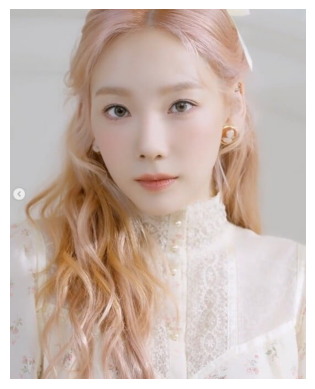

In [66]:
import urllib
from PIL import Image
img = Image.open(urllib.request.urlopen("https://img.hankyung.com/photo/202111/p1065590921493731_758_thum.jpg"))
plt.axis('off')
plt.imshow(img)
plt.show()

In [6]:
x_test, prob = mtcnn(img, return_prob=True)
print(prob)
print(x_test.shape)

0.99262756
torch.Size([3, 160, 160])


In [12]:
x_test

tensor([[[ 0.9102,  0.9258,  0.9102,  ..., -0.5742, -0.5898, -0.6055],
         [ 0.9570,  0.9492,  0.9336,  ..., -0.5117, -0.5117, -0.5039],
         [ 0.9648,  0.8945,  0.8555,  ..., -0.5664, -0.5352, -0.5195],
         ...,
         [ 0.9414,  0.9414,  0.9336,  ..., -0.4883, -0.6445, -0.7617],
         [ 0.9414,  0.9414,  0.9336,  ..., -0.3008, -0.4414, -0.5898],
         [ 0.9414,  0.9414,  0.9414,  ..., -0.1836, -0.2695, -0.4023]],

        [[ 0.3086,  0.3398,  0.3477,  ..., -0.7148, -0.7305, -0.7461],
         [ 0.3555,  0.3555,  0.3477,  ..., -0.6680, -0.6680, -0.6602],
         [ 0.3633,  0.3086,  0.2930,  ..., -0.7227, -0.6914, -0.6758],
         ...,
         [ 0.2852,  0.2852,  0.2773,  ..., -0.6758, -0.8086, -0.9180],
         [ 0.2930,  0.2852,  0.2773,  ..., -0.5117, -0.6367, -0.7617],
         [ 0.2930,  0.2852,  0.2773,  ..., -0.4102, -0.4883, -0.6133]],

        [[-0.1133, -0.0742, -0.0586,  ..., -0.7930, -0.8086, -0.8242],
         [-0.0664, -0.0508, -0.0352,  ..., -0

In [13]:
test_embeddings

NameError: name 'test_embeddings' is not defined

In [21]:
test_embeddings

tensor([[ 0.5834,  0.9271, -0.8658, -0.1984, -0.1042, -0.7620, -0.4151, -0.2645]])

In [8]:
x_aligned=[]
x_aligned.append(x_test)
test_aligned = torch.stack(x_aligned).to(device)
test_embeddings = [model(test_aligned).detach().cpu()]

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x51200 and 100352x128)

In [24]:
test_aligned.shape

torch.Size([1, 3, 160, 160])

In [12]:
test_embeddings

tensor([[ 0.5834,  0.9271, -0.8658, -0.1984, -0.1042, -0.7620, -0.4151, -0.2645]])

In [69]:
print(len(embeddings), len(test_embeddings))

8 1


In [70]:
e1 = test_embeddings
dists = [(e1 - e2).norm().item() for e2 in embeddings]
print(dists)

[4.472289085388184, 10.288548469543457, 6.947718143463135, 3.979768753051758, 8.015825271606445, 6.22360372543335, 5.337413787841797, 5.976510047912598]


In [71]:
print(names[np.argmin(dists)])

sunny


# Test : Multiple faces picture

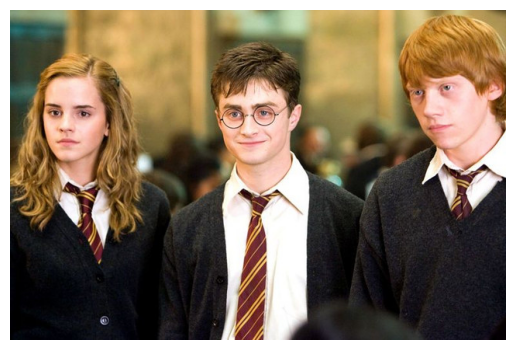

In [89]:
import urllib
from PIL import Image
# img = plt.imread("../data/snsd/소녀시대.jpg")
img = Image.open(urllib.request.urlopen("https://i.ibb.co/y6T6J4c/b9cd1361454792c038d03eb158a7cc91.jpg"))
plt.axis('off')
plt.imshow(img)
plt.show()

In [90]:
mtcnn = MTCNN(keep_all=True)

In [91]:
x_test, prob = mtcnn(img, return_prob=True)
print(prob)
print(x_test.shape)

[0.9991272 0.9999962 0.9999336]
torch.Size([3, 3, 160, 160])


In [92]:
test_aligned = x_test.to(device)
test_embeddings = resnet(test_aligned).detach().cpu()

In [93]:
dists = [[(e1 - e2).norm().item() for e2 in embeddings] for e1 in test_embeddings]
test_no=[]
[test_no.append(i) for i in range(len(test_embeddings))]
print(pd.DataFrame(dists, columns=names, index=test_no))

   angelina_jolie  angelina_jolie  ariana_grande  ariana_grande  \
0        1.271687        0.584632       6.373931       2.099184   
1        1.422561        0.723121       6.499218       2.242584   
2        2.693608        1.837439       4.831940       0.662856   

   bradley_cooper     harry  kate_siegel  paul_rudd       ron  shea_whigham  
0        4.058092  1.574510     4.105058   3.279569  0.584131      4.341037  
1        3.931566  1.619581     4.157401   3.164586  0.792763      4.220667  
2        3.094545  0.234199     2.958482   2.297125  2.038183      3.297981  


In [96]:
dists = [[(e1 - e2).norm().item() for e2 in embeddings] for e1 in test_embeddings]
for dist in dists:
    if any(e<1 for e in dist):
        print(names[np.argmin(dist)])
    else:
        print('unknown')

ron
angelina_jolie
harry
